In [1]:
# pip install nlp
import nlp
import numpy as np

In [2]:
# View all the available datasets 
print([dataset.id for dataset in nlp.list_datasets()])

['aeslc', 'ai2_arc', 'anli', 'art', 'billsum', 'blimp', 'blog_authorship_corpus', 'boolq', 'break_data', 'cfq', 'civil_comments', 'cmrc2018', 'cnn_dailymail', 'coarse_discourse', 'com_qa', 'commonsense_qa', 'coqa', 'cornell_movie_dialog', 'cos_e', 'cosmos_qa', 'crime_and_punish', 'csv', 'definite_pronoun_resolution', 'discofuse', 'drop', 'empathetic_dialogues', 'eraser_multi_rc', 'esnli', 'event2Mind', 'flores', 'fquad', 'gap', 'germeval_14', 'gigaword', 'glue', 'hansards', 'hellaswag', 'imdb', 'jeopardy', 'json', 'kor_nli', 'lc_quad', 'librispeech_lm', 'lm1b', 'math_dataset', 'math_qa', 'mlqa', 'movie_rationales', 'multi_news', 'multi_nli', 'multi_nli_mismatch', 'newsroom', 'openbookqa', 'opinosis', 'para_crawl', 'qa4mre', 'qangaroo', 'qasc', 'quarel', 'quartz', 'quoref', 'race', 'reclor', 'reddit', 'reddit_tifu', 'scan', 'scicite', 'scientific_papers', 'scifact', 'sciq', 'scitail', 'sentiment140', 'snli', 'social_i_qa', 'squad', 'squad_it', 'squad_v1_pt', 'squad_v2', 'super_glue', 't

In [3]:
# Load dataset
news_dataset = nlp.load_dataset('civil_comments')

Using custom data configuration default


In [4]:
print('training set contains: ' + str(len(news_dataset['train'])) + ' examples')
print('test set contains: ' + str(len(news_dataset['test'])) + ' examples')


training set contains: 1804874 examples
test set contains: 97320 examples


In [5]:
print('Positive example.')
print(news_dataset['train'][0])

Positive example.
{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [6]:
print('Negative example.')
print(news_dataset['train'][4])

Negative example.
{'text': 'haha you guys are a bunch of losers.', 'toxicity': 0.8936170339584351, 'severe_toxicity': 0.021276595070958138, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.8723404407501221, 'identity_attack': 0.021276595070958138, 'sexual_explicit': 0.0}


# Challenge: create a model for moderating comments in the test set. 

In [7]:
type(news_dataset['train'])

nlp.arrow_dataset.Dataset

### Let's try to use this as reference moving forward:
[concrete NLP tutorial](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb)

In [8]:
import keras
import nltk
import pandas as pd
import re
import codecs
# numpy already imported

Using TensorFlow backend.


In [9]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df


In [10]:
# standardize text -> remove weird characters and make everything lower
# also convert arrow_dataset.DataSet to standard pandas.DataFrame
training_set = standardize_text(pd.DataFrame(news_dataset['train']), 'text')
test_set     = standardize_text(pd.DataFrame(news_dataset['test']), 'text')

In [11]:
training_set.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"this is so cool it's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,thank you!! this would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,this is such an urgent design problem kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,is this something i'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [12]:
# now let's generate a classification
from enum import Enum
class CommentClassification(Enum):
    OK            = 1
    LOW_SEVERITY  = 2
    HIGH_SEVERITY = 3

rating_types = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

# this is a very basic attempt to classify each sample using ratings
def classify_sample(sample):
    '''
    return "OK", "LOW_SEVERITY", "HIGH_SEVERITY" 
    '''
    combined_rating = sum([sample[rating] for rating in rating_types])
    if combined_rating < 0.9:
        return CommentClassification.OK
    if combined_rating < 1.2:
        return CommentClassification.LOW_SEVERITY
    return CommentClassification.HIGH_SEVERITY

In [13]:
def classify_and_update_dataset(dataset) :
    # use classification algo above to classify each row of dataset
    classifications = [classify_sample(dataset.loc[i,:]) for i in range(len(dataset))]
    
    # drop rating types as they won't be used any further in this experiment
    new_dataset = dataset.drop(rating_types,1)
    
    # add basic classifications to data
    new_dataset.loc[:,('classification')] = classifications
    
    # add class label 1 - 2 - 3 for each classification
    new_dataset.loc[:,('class_label')] = [classification.value for classification in classifications]
    
    return new_dataset
    

In [14]:
# now add classifications using rating values, and drop ratings from frames
training_set = classify_and_update_dataset(training_set)
test_set     = classify_and_update_dataset(test_set)

In [15]:
training_set.to_csv("training_set.csv")
training_set.head()

,text,classification,class_label
0,"this is so cool it's like, 'would you want yo...",CommentClassification.OK,1
1,thank you!! this would make my life a lot less...,CommentClassification.OK,1
2,this is such an urgent design problem kudos t...,CommentClassification.OK,1
3,is this something i'll be able to install on m...,CommentClassification.OK,1
4,haha you guys are a bunch of losers,CommentClassification.HIGH_SEVERITY,3


In [16]:
training_set.groupby("class_label").count()

,text,classification
class_label,,
1,1615062,1615062
2,65460,65460
3,124352,124352


In [17]:
# running on my remote toy server
# ... which isn't very good
# lets try to get the data ... closer
# Also let's try to get similar sizes of training
# drop 1415062 rows with class_label==1
training_set = training_set.drop(np.random.choice(training_set[training_set['class_label']==1].index,size=1415062,replace=False))
training_set.head()

,text,classification,class_label
1,thank you!! this would make my life a lot less...,CommentClassification.OK,1
4,haha you guys are a bunch of losers,CommentClassification.HIGH_SEVERITY,3
5,ur a sh tty comment,CommentClassification.HIGH_SEVERITY,3
6,hahahahahahahahhha suck it,CommentClassification.HIGH_SEVERITY,3
11,this is a great story man i wonder if the pe...,CommentClassification.LOW_SEVERITY,2


In [18]:
np.shape(training_set)

(389812, 3)

In [19]:
from nltk.tokenize import RegexpTokenizer

# tokenize sentences to a list of separate words

tokenizer = RegexpTokenizer(r'\w+')

training_set["tokens"] = training_set["text"].apply(tokenizer.tokenize)

test_set["tokens"] = test_set["text"].apply(tokenizer.tokenize)

training_set.head()

,text,classification,class_label,tokens
1,thank you!! this would make my life a lot less...,CommentClassification.OK,1,"[thank, you, this, would, make, my, life, a, l..."
4,haha you guys are a bunch of losers,CommentClassification.HIGH_SEVERITY,3,"[haha, you, guys, are, a, bunch, of, losers]"
5,ur a sh tty comment,CommentClassification.HIGH_SEVERITY,3,"[ur, a, sh, tty, comment]"
6,hahahahahahahahhha suck it,CommentClassification.HIGH_SEVERITY,3,"[hahahahahahahahhha, suck, it]"
11,this is a great story man i wonder if the pe...,CommentClassification.LOW_SEVERITY,2,"[this, is, a, great, story, man, i, wonder, if..."


In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in training_set["tokens"] for word in tokens]

sentence_lengths = [len(tokens) for tokens in training_set["tokens"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

20545854 words total, with a vocabulary size of 132739
Max sentence length is 312


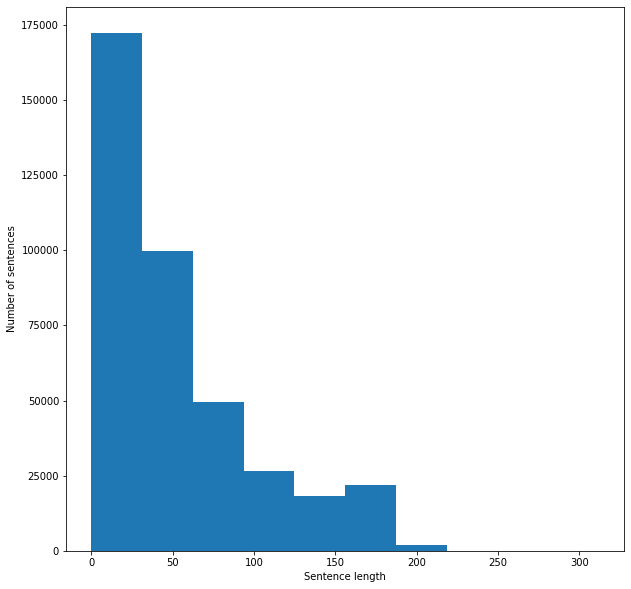

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [22]:
# Bag of Words Counts

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train = training_set["text"].tolist()
y_train = training_set["class_label"].tolist()
X_test  = test_set["text"].tolist()
y_test  = test_set["class_label"].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

/home/wanderingking/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


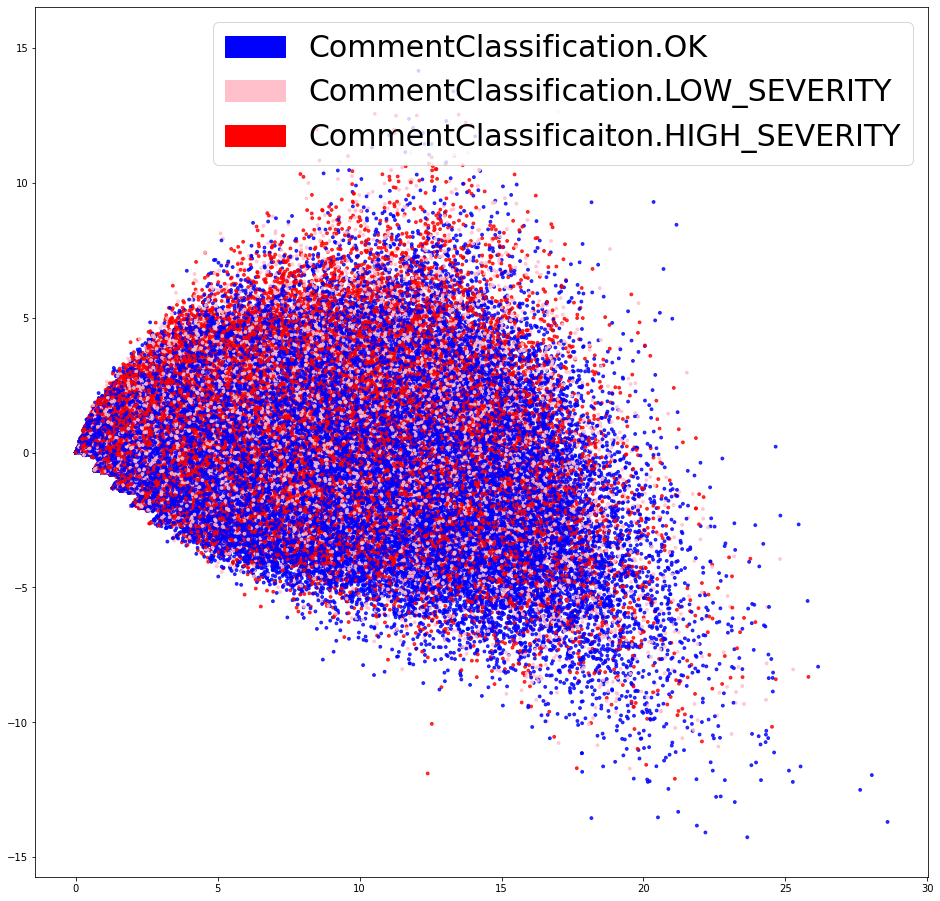

In [23]:
# Visualize the embeddings
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=3)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','pink','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            blue_patch = mpatches.Patch(color='blue', label='CommentClassification.OK')
            pink_patch = mpatches.Patch(color='pink', label='CommentClassification.LOW_SEVERITY')
            red_patch  = mpatches.Patch(color='red',  label='CommentClassificaiton.HIGH_SEVERITY')
            plt.legend(handles=[blue_patch, pink_patch, red_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show() # embeddings don't look very cleanly separated

In [ ]:
# try to fit a logistic regression classifier first

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

